In [1]:
import numpy as np
import pandas as pd
import os
import math
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

from mpl_toolkits.mplot3d import Axes3D

import cv2

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
resdf_path = "gdrive/MyDrive/ham_work_folder/df_with_fst.csv"
resdf = pd.read_csv(resdf_path)
resdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     10015 non-null  int64  
 1   lesion_id      10015 non-null  object 
 2   image_id       10015 non-null  object 
 3   dx             10015 non-null  object 
 4   dx_type        10015 non-null  object 
 5   age            9958 non-null   float64
 6   sex            10015 non-null  object 
 7   localization   10015 non-null  object 
 8   path           10015 non-null  object 
 9   cell_type      10015 non-null  object 
 10  cell_type_idx  10015 non-null  int64  
 11  ita            10015 non-null  float64
 12  fts            10015 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 1017.3+ KB


In [4]:
# Rename the columns
new_column_names = {'path': 'filepaths', 'cell_type_idx': 'labels'}
resdf = resdf.rename(columns=new_column_names)
resdf["labels"] = resdf['labels'].apply(lambda x: str(x))

In [5]:
resdf.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,fts
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,gdrive/MyDrive/ham/HAM10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,101.798089,1
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,gdrive/MyDrive/ham/HAM10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,103.112612,1
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,gdrive/MyDrive/ham/HAM10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,92.554285,1
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,gdrive/MyDrive/ham/HAM10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,89.416812,1
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,gdrive/MyDrive/ham/HAM10000_images_part_2/ISIC...,Benign keratosis-like lesions,2,96.993318,1


In [6]:
# Return skin color of centroid
def centroid_skin_color(image_path):
    color_space = "RGB"
    color_attributes = list(color_space)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_df = pd.DataFrame(img.reshape(-1, 3), columns=color_attributes)
    kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
    kmeans.fit(color_df)
    color_df["Cluster"] = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Calculate mean intensity or luminance for each centroid
    mean_intensity = centroids.mean(axis=1)

    # Determine which centroid is "dark" based on mean intensity
    skin_centroid_index = np.argmax(mean_intensity)
    skin_centroid = centroids[skin_centroid_index]

    print("Centroids: ", centroids)
    print("Mean Intensity: ", mean_intensity)
    print("Skin Centroid: ", skin_centroid)

    return skin_centroid

# Representative skin color

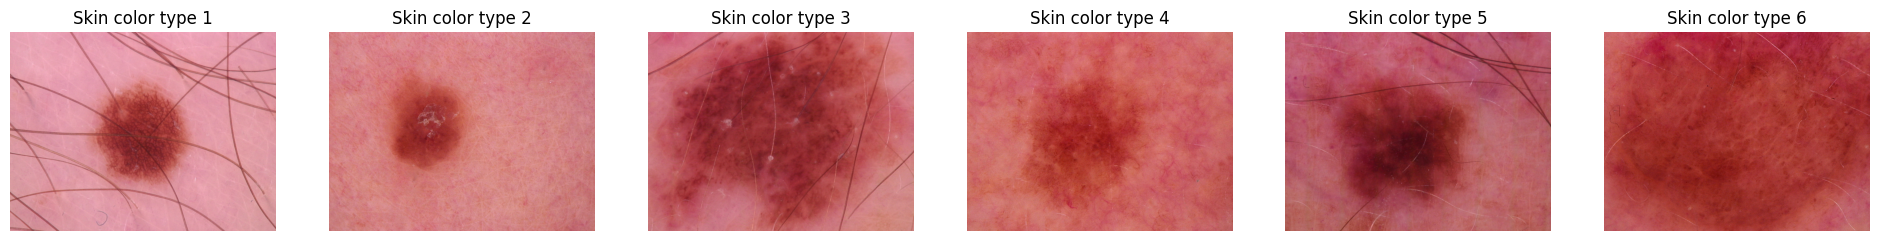

In [20]:
# Randomly picked representative skin colors
represent_colors = {}
represent_colors[1] = resdf[resdf["fts"] == 1].sample(n=1, random_state=10)["filepaths"].iloc[0]
represent_colors[2] = resdf[resdf["fts"] == 2].sample(n=1, random_state=10)["filepaths"].iloc[0]
represent_colors[3] = resdf[resdf["fts"] == 3].sample(n=1, random_state=42)["filepaths"].iloc[0] # Too much hair random_state 10
represent_colors[4] = resdf[resdf["fts"] == 4].sample(n=1, random_state=10)["filepaths"].iloc[0]
represent_colors[5] = resdf[resdf["fts"] == 5].sample(n=1, random_state=10)["filepaths"].iloc[0]
represent_colors[6] = resdf[resdf["fts"] == 6].sample(n=1, random_state=10)["filepaths"].iloc[0]

fig, axes = plt.subplots(1, 6, figsize=(24, 4), facecolor='white')

for i in range(6):
    img = cv2.imread(represent_colors[i + 1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title('Skin color type ' + str(i + 1))

plt.show()

# Create converted skin color images

In [21]:
# Replace the meta file to create image only for test data
resdf_path = "gdrive/MyDrive/ham_work_folder/test_df.csv"
resdf = pd.read_csv(resdf_path)

In [23]:
# Create folders to store converted images
def create_folder(folder_name):

    folder_path = os.path.join("gdrive/MyDrive/ham_work_folder/", folder_name)

    # Check if the folder already exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

create_folder("cv_skin_area")
create_folder("cv_all_area")

for i in range(6):
    create_folder("cv_skin_area/" + str(i + 1))
    create_folder("cv_all_area/" + str(i + 1))

In [24]:
def is_darker(color_space, centroid1, centroid2):

    if color_space == "HSV":
        # Use Value
        return centroid1[2] > centroid2[2]
    elif color_space == "RGB":
        # Calculate the average intensity of the two centroids
        intensity1 = (centroid1[0] + centroid1[1] + centroid1[2]) / 3.0
        intensity2 = (centroid2[0] + centroid2[1] + centroid2[2]) / 3.0
        return intensity1 > intensity2
    else:
        # Use the L* (luminance) component in the L*a*b* color space (index 0)
        return centroid1[0] > centroid2[0]

In [25]:
# Apply skin color change without abnormal areas
def change_skin_color(image_path, desired_color, fitzpatricks):
    color_space = "RGB"
    color_attributes = list(color_space)
    img_size = (310,640)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_df = pd.DataFrame(img.reshape(-1, 3), columns=color_attributes)

    kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
    kmeans.fit(color_df)
    color_df["Cluster"] = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Create a mask for the darker cluster
    darker_cluster = 0 if is_darker(color_space, centroids[0], centroids[1]) else 1
    mask_darker = color_df["Cluster"] == darker_cluster

    # Create a mask with the same shape as the image
    mask_darker = mask_darker.values.reshape(img.shape[0], img.shape[1])
    mask_darker = mask_darker.astype(np.uint8)
    masked_img = cv2.bitwise_and(img, img, mask=mask_darker)

    skin = np.any(masked_img != [0, 0, 0], axis=-1).astype(np.uint8)

    # get average bgr color
    ave_color = cv2.mean(img, mask=skin)[:3]

    # compute difference colors and make into an image the same size as input
    diff_color = desired_color - ave_color

    # apply the color change only to the skin pixels
    new_img = img.copy()
    new_img[skin != 0, :] = (new_img[skin != 0, :] + diff_color).clip(0, 255)

    new_filepath = "gdrive/MyDrive/ham_work_folder/cv_skin_area/{0}/{1}".format(fitzpatricks, os.path.basename(image_path))
    new_img = Image.fromarray(new_img)
    new_img.save(new_filepath)


    # apply the color change all areas.
    new_img = img.copy()
    new_img[:] = (new_img[:] + diff_color).clip(0, 255)

    new_filepath = "gdrive/MyDrive/ham_work_folder/cv_all_area/{0}/{1}".format(fitzpatricks, os.path.basename(image_path))
    new_img = Image.fromarray(new_img)
    new_img.save(new_filepath)

for k, v in represent_colors.items():
    new_skin_color = centroid_skin_color(v)
    desired_color = tuple(new_skin_color)
    desired_color = np.asarray(desired_color, dtype=np.float64)

    for p in resdf["filepaths"]:
        change_skin_color(p, desired_color, str(k))

Centroids:  [[225.05956114 152.60691178 164.63050374]
 [166.77902622  75.01169372  75.60932168]]
Mean Intensity:  [180.76565889 105.80001387]
Skin Centroid:  [225.05956114 152.60691178 164.63050374]
Centroids:  [[169.79076172  64.46395971  58.88562323]
 [212.14568001 128.4415988  129.19587545]]
Mean Intensity:  [ 97.71344822 156.59438475]
Skin Centroid:  [212.14568001 128.4415988  129.19587545]
Centroids:  [[155.04933421  52.2715631   56.8637536 ]
 [200.17029951 107.21500615 112.33650018]]
Mean Intensity:  [ 88.0615503  139.90726861]
Skin Centroid:  [200.17029951 107.21500615 112.33650018]
Centroids:  [[178.47112259  59.56790436  53.04027306]
 [204.75906685 101.24902156  99.4876251 ]]
Mean Intensity:  [ 97.02643334 135.16523784]
Skin Centroid:  [204.75906685 101.24902156  99.4876251 ]
Centroids:  [[126.22954384  35.90748851  41.63425655]
 [181.7115679   89.39571249  99.65035534]]
Mean Intensity:  [ 67.92376297 123.58587858]
Skin Centroid:  [181.7115679   89.39571249  99.65035534]
Centr

In [26]:
# stored file paths for created images
for k, v in represent_colors.items():
    resdf["filepaths_skin_{}".format(str(k))] = "gdrive/MyDrive/ham_work_folder/cv_skin_area/{}/".format(str(k)) + resdf["filepaths"].str.split("/").str[-1]
    resdf["filepaths_all_{}".format(str(k))] = "gdrive/MyDrive/ham_work_folder/cv_all_area/{}/".format(str(k)) + resdf["filepaths"].str.split("/").str[-1]

resdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      1002 non-null   int64  
 1   Unnamed: 0        1002 non-null   int64  
 2   lesion_id         1002 non-null   object 
 3   image_id          1002 non-null   object 
 4   dx                1002 non-null   object 
 5   dx_type           1002 non-null   object 
 6   age               991 non-null    float64
 7   sex               1002 non-null   object 
 8   localization      1002 non-null   object 
 9   filepaths         1002 non-null   object 
 10  cell_type         1002 non-null   object 
 11  labels            1002 non-null   int64  
 12  ita               1002 non-null   float64
 13  fts               1002 non-null   int64  
 14  filepaths_skin_1  1002 non-null   object 
 15  filepaths_all_1   1002 non-null   object 
 16  filepaths_skin_2  1002 non-null   object 


In [ ]:
# Change the image paths when the original skin types
# Keep color changed to original color to compare later if needs
# We don't replace with original image to purely measure the color difference with same condition
# for k, v in represent_colors.items():
#    resdf.loc[resdf["fts"] == k, "filepaths_skin_{}".format(str(k))] = resdf["filepaths"]
#    resdf.loc[resdf["fts"] == k, "filepaths_all_{}".format(str(k))] = resdf["filepaths"]

In [27]:
# to check
resdf.head()[["fts", "filepaths_skin_1", "filepaths_all_1"]]

,fts,filepaths_skin_1,filepaths_all_1
0,1,gdrive/MyDrive/ham_work_folder/cv_skin_area/1/...,gdrive/MyDrive/ham_work_folder/cv_all_area/1/I...
1,1,gdrive/MyDrive/ham_work_folder/cv_skin_area/1/...,gdrive/MyDrive/ham_work_folder/cv_all_area/1/I...
2,5,gdrive/MyDrive/ham_work_folder/cv_skin_area/1/...,gdrive/MyDrive/ham_work_folder/cv_all_area/1/I...
3,1,gdrive/MyDrive/ham_work_folder/cv_skin_area/1/...,gdrive/MyDrive/ham_work_folder/cv_all_area/1/I...
4,1,gdrive/MyDrive/ham_work_folder/cv_skin_area/1/...,gdrive/MyDrive/ham_work_folder/cv_all_area/1/I...


In [28]:
resdf.to_csv("gdrive/MyDrive/ham_work_folder/df_with_fst_aft_conversion.csv")